In [1]:
import torch as t
import pandas as pd
# import numpy as np
# from tqdm import tqdm

from src.preprocess import *
from src.models import *
from src.utils import *

from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.simplefilter('ignore')


In [2]:
# setting up
DEVICE = 'cuda' if t.cuda.is_available() else 'cpu'
DEVICE = 'mps' if t.backends.mps.is_available() else DEVICE
params = {
    'DATASET_PATH' : './dataset/result.csv',
    'LOOK_FWD' : 700,
    'W_SIZE' : 400,
    'THR' : 0.000001,
    'TRAIN_TEST_R' : 0.8,
    'TRAIN_VAL_R' : 0.8,
    'HIDDEN' : 30,
    'N_LAYERS' : 3,
    'BATCH_SIZE' : 256,
    'SAMPLES' : 5000000,
    'W_STEP' : 2
}

locals().update(params)

In [3]:
import pickle

unzip_dataset('./dataset/')
pckl_name = './dataset/dataset.pckl'
if os.path.isfile(pckl_name):
    print('loading the dataset...')
    dataset_ = pd.read_pickle(pckl_name)
else: 
    dataset_ = pd.read_csv(DATASET_PATH, index_col=0)
    print('saving the dataset...')
    dataset_.to_pickle(pckl_name)

dataset = dataset_[:SAMPLES]
dataset.shape

Dataset already extracted
loading the dataset...


(4382993, 79)

In [4]:
labels_name = './dataset/labels.pckl'
if os.path.isfile(labels_name):
    with open('./dataset/labels.pckl', 'rb') as f:
        labels = pickle.load(f)
else:
    labels = generate_labels(dataset_, LOOK_FWD, THR)
    with open('./dataset/labels.pckl', 'wb+') as f:
        pickle.dump(labels, f)
        
labels = labels[LOOK_FWD:dataset.shape[0]:W_STEP]
dataset_ = None
labels.shape

(2190797,)

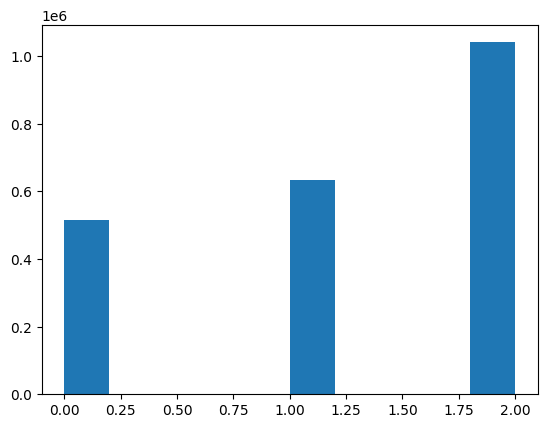

In [5]:
import matplotlib.pyplot as plt
plt.hist(labels)
plt.show()

In [6]:
labels.shape

(2190797,)

In [7]:
pipe = Pipe(W_SIZE, window_step=2)

train_index = int((dataset.shape[0] - LOOK_FWD * 2 - W_SIZE) * TRAIN_TEST_R)
test_index_start = train_index + W_SIZE
ds_train = dataset[:train_index]
ds_test = dataset[test_index_start: - LOOK_FWD * 2]

dataset = None

pipe.fit(ds_train)

train_t = pipe.transform(ds_train)
test_t = pipe.transform(ds_test)

train_l_t = t.tensor(labels[:train_t.shape[0]])
test_l_t = t.tensor(labels[test_index_start // W_STEP:test_index_start // W_STEP + test_t.shape[0]])

train_val_idx = int(train_l_t.shape[0] * TRAIN_VAL_R)

train_ds = t.utils.data.TensorDataset(train_t[:train_val_idx], train_l_t[:train_val_idx])
val_ds = t.utils.data.TensorDataset(train_t[train_val_idx:], train_l_t[train_val_idx:])
test_ds = t.utils.data.TensorDataset(test_t, test_l_t)

train_dl = t.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = t.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = t.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
t.save(test_ds, './dataset/test_tensors.t')

In [10]:
model = Att_GRU(test_t.shape[2],
                  n_layers=N_LAYERS,
                  hidden=HIDDEN,
                  device=DEVICE,
                  window=W_SIZE).to(device=DEVICE)

# with open('./models/model_2023-05-01 14:20:37_final', 'rb') as f:
#       model = t.load(f)['model']

optimizer = t.optim.Adam(model.parameters(), lr=5e-4)
lf = t.nn.CrossEntropyLoss()
sm = SummaryWriter('./runs')

train(train_dl, val_dl, model, optimizer, lf, 30, device=DEVICE, sm=sm,
      save_on=5, save_params=params)
test_results = eval(test_dl, model, lf, DEVICE)
print(test_results)

train_loss: 0.936, train_acc_pre_rec: 0.595, 0.600, 0.595; || eval_loss: 0.985, eval_acc_pre_rec 0.539, 0.549, 0.539; || local_loss: 0.890:  17%|█▋        | 5/30 [16:15<1:21:26, 195.44s/it]        

model saved


train_loss: 0.934, train_acc_pre_rec: 0.598, 0.602, 0.598; || eval_loss: 0.986, eval_acc_pre_rec 0.536, 0.550, 0.536; || local_loss: 0.927:  33%|███▎      | 10/30 [32:36<1:05:41, 197.06s/it]

model saved


train_loss: 0.934, train_acc_pre_rec: 0.599, 0.603, 0.599; || eval_loss: 0.988, eval_acc_pre_rec 0.535, 0.551, 0.535; || local_loss: 0.918:  43%|████▎     | 13/30 [43:12<56:30, 199.41s/it]  


KeyboardInterrupt: 

In [ ]:
save_model(model, params, test_results, pipe, postfix='final')